# NorthernTerrority_PV_Precip_Scores

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from PreprocessData import * # import from custom transformers 
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
site_list = pd.read_csv('../DATASETS/Sites_Bigger_Subset_20240124/ausplots_bigger_subset.csv').copy()

In [3]:
unique_list = np.unique(site_list.site_location_name)
NT_sites = []
for site in unique_list:
    if site[:2] == "NT": # collect all sites that starts with NT 
        NT_sites.append(site)

In [4]:
NT_sites

['NTADAC0001',
 'NTADMR0001',
 'NTAFIN0003',
 'NTAFIN0006',
 'NTAFIN0015',
 'NTAFIN0018',
 'NTAGFU0014',
 'NTAGFU0020',
 'NTAGFU0030',
 'NTAGFU0034',
 'NTASTU0004',
 'NTTDMR0003']

In [5]:

window_length = 5
# savgol_filter parameters 
window_length_smooth = 15
polyorder = 4 


site_location_names =  NT_sites

scores = pd.DataFrame({'site_location_name': [site_location_names[0]],
                      'lag':[pd.NA],
                      'window': [pd.NA],
                      'R2': [pd.NA]})

for site_location_name in site_location_names:

    site = pd.read_csv(f'../DATASETS/DEA_FC_PROCESSED/SPATIAL_AND_UE_FILTER/{site_location_name}.csv', parse_dates=['time'])

    time_fc_pipeline = Pipeline([
        ('preprocess_fc_time_series', preprocess_fc_time_series(window_length = window_length_smooth, polyorder = polyorder)),
        ('time_attributes_adder', time_attributes_adder()),
     ])
    site_resampled = time_fc_pipeline.fit_transform(site)

    precip = pd.read_csv(f'../DATASETS/Climate_Gridded/Precip/{site_location_name}_1987_2022.csv', parse_dates=['time'])

    lag = [i for i in range(1,50)]
    window = [i for i in range(1,50)]

    models_fitted_count = len(lag)*len(window)
    m = 0


    for w in window:

        for l in lag:

            time_climate_pipeline = Pipeline([
                    ('preprocess_climate_time_series', preprocess_climate_time_series()),
                    ('climate_time_series_downsample', climate_time_series_downsample(start_time = site_resampled.index[0], resample_method = 'sum')),
                    ('time_attributes_adder', time_attributes_adder()),
                    ('climate_time_series_attributes_adder', climate_time_series_attributes_adder(window = w, lag = l))
            ])

            precip_new = time_climate_pipeline.fit_transform(precip)
            temp = site_resampled.copy().merge(precip_new, how = 'left', left_index = True, right_index = True, validate = "one_to_one",
                                                  suffixes = ('', '_DUPLICATE'))
            temp = temp.drop(columns =  temp.filter(regex = '_DUPLICATE$').columns)
            temp = temp.copy()

            # Now fit a model to see the R2 score 
            FEATURES = 'precip_rolling'
            site_merged_model = temp.copy().dropna(subset = FEATURES)
            X = site_merged_model['precip_rolling'].copy().dropna().to_numpy().reshape(-1,1)
            y = site_merged_model['pv_filter'].to_numpy()
            score = LinearRegression().fit(X,y).score(X,y)

            row = pd.Series({'site_location_name': site_location_name, 'lag': l, 'window': w, 'R2': score})
            scores = pd.concat([scores, row.to_frame().T], ignore_index=True)
            m += 1 

            if m % 100 == 0:
                print(m)


scores = scores.dropna()

            Unnamed: 0              x             y         bs         pv  \
time                                                                        
1987-09-19         1.0  692755.000000  8.544725e+06   1.338843  47.016529   
1987-10-05         1.5  692755.000000  8.544725e+06   0.669421  45.785124   
1987-10-21         2.0  692755.000000  8.544725e+06   0.000000  44.553719   
1987-11-06         3.0  692755.000000  8.544725e+06   0.322314  45.801653   
1987-11-22         4.0  692755.000000  8.544725e+06   0.776860  62.181818   
...                ...            ...           ...        ...        ...   
2023-01-25       721.2  692756.878261  8.544723e+06  11.319454  60.975839   
2023-02-10       721.4  692756.408696  8.544724e+06   9.169342  60.769069   
2023-02-26       721.6  692755.939130  8.544724e+06   7.019231  60.562300   
2023-03-14       721.8  692755.469565  8.544725e+06   4.869120  60.355530   
2023-03-30       722.0  692755.000000  8.544725e+06   2.719008  60.148760   

In [7]:
# scores.to_csv('NT_bigger_Subset_Scores.csv') # save to csv

In [8]:
site_list = pd.read_csv('../DATASETS/Sites_Bigger_Subset_20240124/ausplots_bigger_subset.csv').copy()
site_scores = pd.read_csv('NT_bigger_Subset_Scores.csv', usecols =  ['site_location_name', 'lag', 'window', 'R2'])

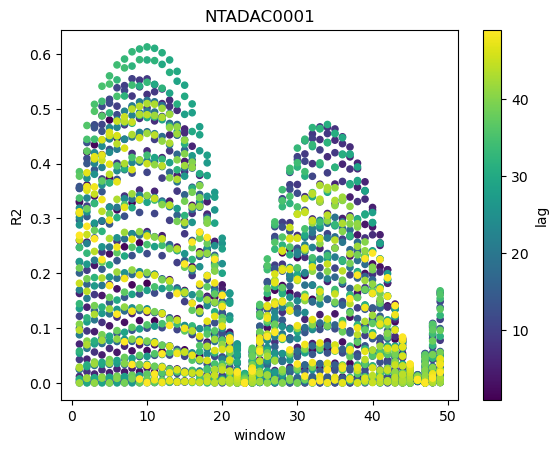

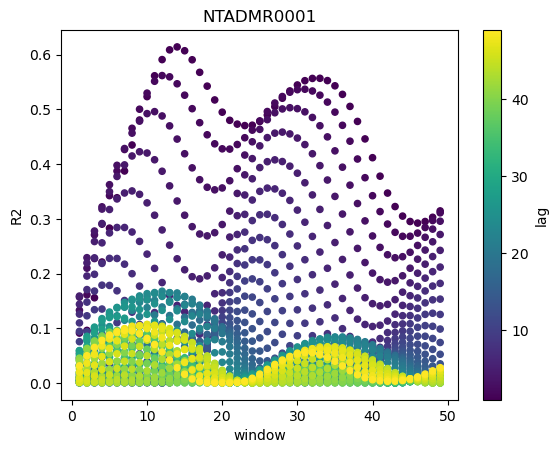

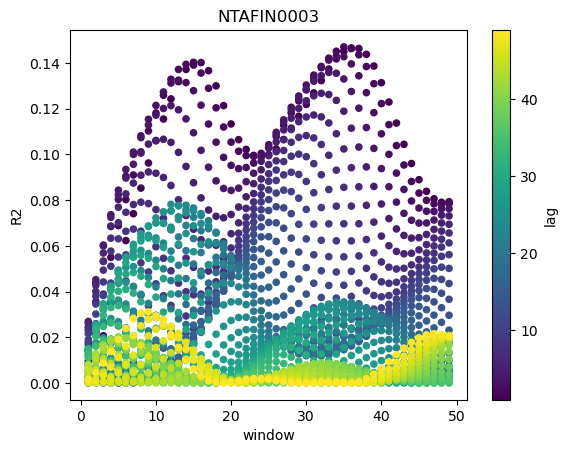

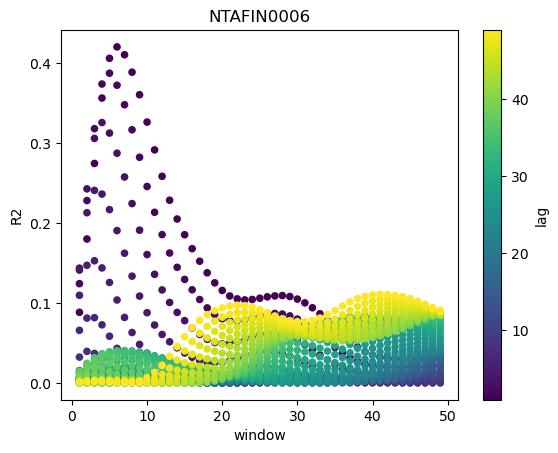

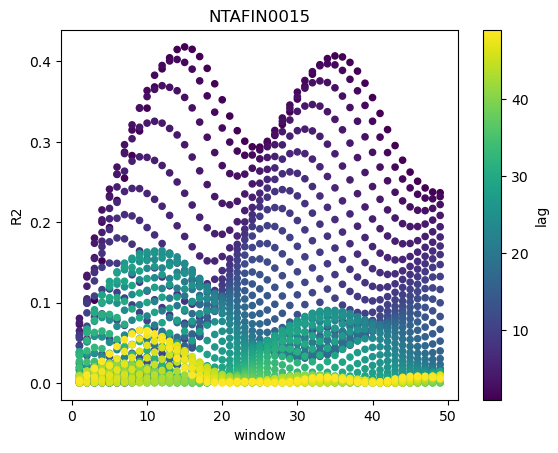

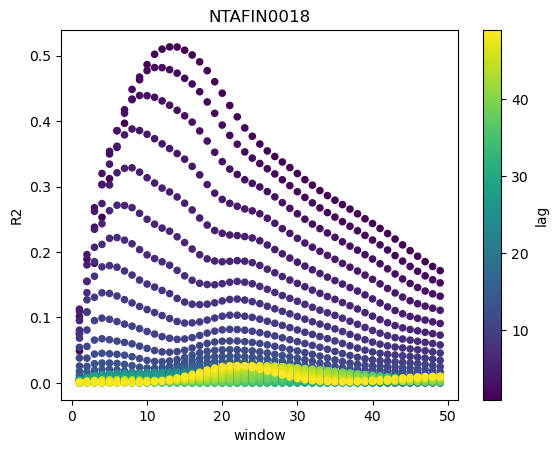

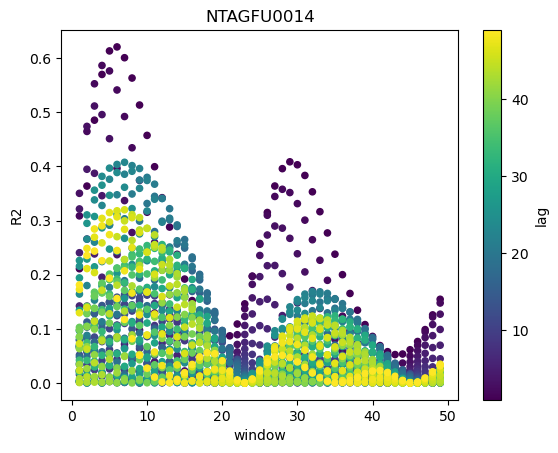

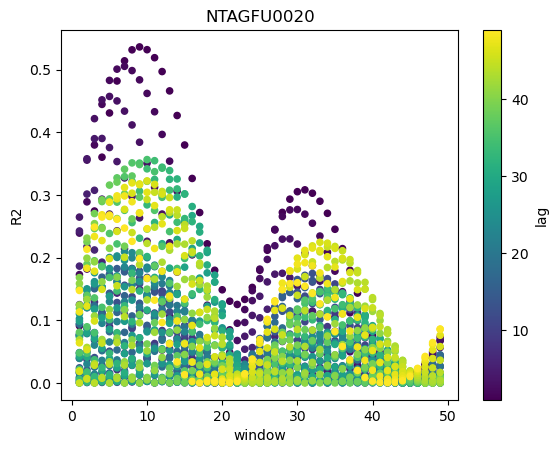

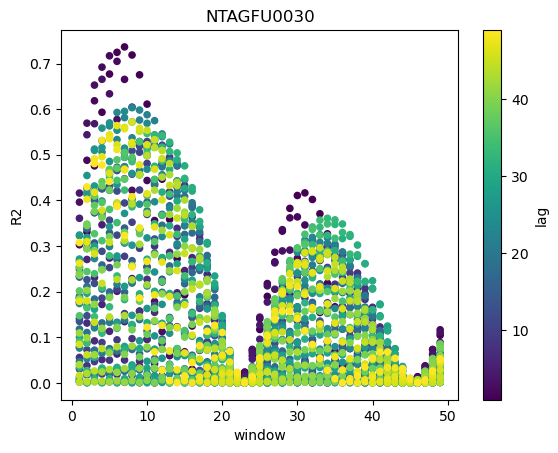

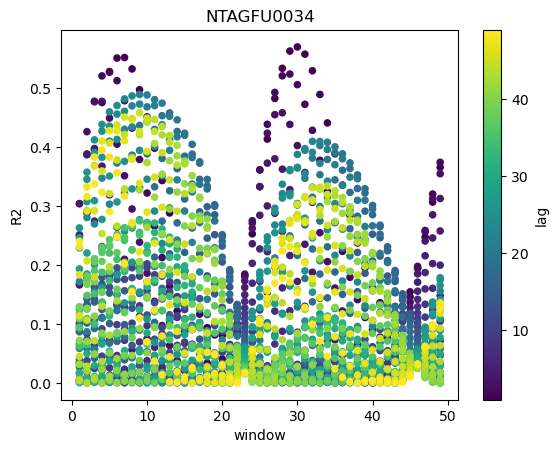

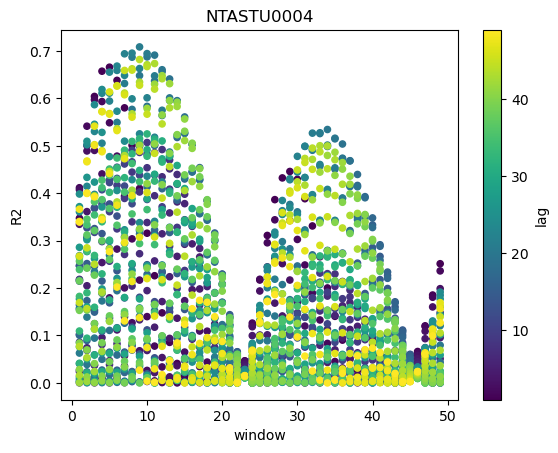

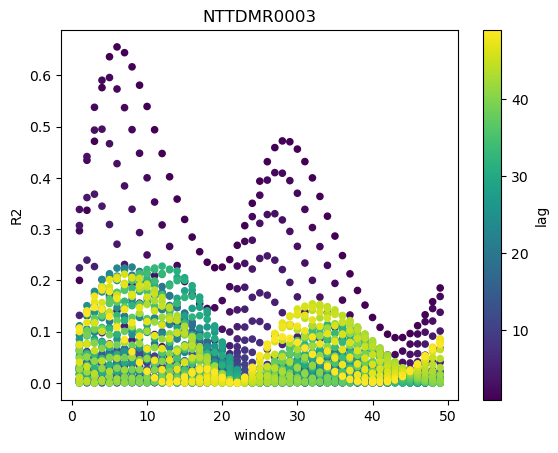

In [9]:
site_scores_grp = site_scores.groupby('site_location_name')

for key in site_scores_grp.groups.keys():
    site = site_scores_grp.get_group(key)
    first_index = site.index[0] # information will be constant per group so take the first one for simplicity
    site.plot.scatter(x = 'window', y = 'R2', c = 'lag', colormap = 'viridis', title = f'{key}')
    
    

In [10]:

site_location_name = 'NSANSS0001'
time_lag = 5
window_length = 5
month_baseline = 3

# savgol_filter parameters 
window_length_smooth = 15
polyorder = 4 

def get_site_data(site_location_name, time_lag = 5, window_length = 5, month_baseline = 3, window_length_smooth = 15, polyorder = 4):

    historical_fire_ds = gpd.read_file('../DATASETS/AusPlots_Historical_BurnDates.shp', parse_dates = ['igntn_d'])
    historical_fire_pipeline = Pipeline([
        ('historical_burn_date_preprocess', historical_burn_date_preprocess(site_location_name))
    ])
    historical_fire_ds = historical_fire_pipeline.fit_transform(historical_fire_ds)
    print(historical_fire_ds)
    
    site = pd.read_csv(f'../DATASETS/DEA_FC_PROCESSED/SPATIAL_AND_UE_FILTER/{site_location_name}.csv', parse_dates=['time'])
    
    # Check if the fire dataset is empty; no recorded fires for the particular site
#     if not historical_fire_ds.empty:
    
#         time_fc_pipeline = Pipeline([
#             ('preprocess_fc_time_series', preprocess_fc_time_series(window_length = window_length_smooth, polyorder = polyorder)),
#             ('time_attributes_adder', time_attributes_adder()),
#             ('historical_burn_date_attribute_adder', historical_burn_date_attribute_adder(historical_fire_ds, time_lag = time_lag))
#          ])
#         site_resampled = time_fc_pipeline.fit_transform(site)

#         ## Filter out the rows that were recently affected by fire 
#         fire_filter = site_resampled[(site_resampled['days_since_fire'] >= 0) & (site_resampled['days_since_fire'] <= 32)]
#     else:
        # Don't perform filtering or add the fire date attributes
    
    # Note, this is a part of the if statement, temporarily here to generate plots without errors 
    time_fc_pipeline = Pipeline([
            ('preprocess_fc_time_series', preprocess_fc_time_series(window_length = window_length_smooth, polyorder = polyorder)),
            ('time_attributes_adder', time_attributes_adder()),
         ])
    site_resampled = time_fc_pipeline.fit_transform(site)
    
    
    
    climate_variables = pd.DataFrame({'climate_var': ['Precip'],
                                     'resample_type': ['sum']})
    datasets = dict()

    for index, row in climate_variables.iterrows():

        climate = pd.read_csv(f'../DATASETS/Climate_Gridded/{row["climate_var"]}/{site_location_name}_1987_2022.csv', parse_dates=['time'])

        datasets[row['climate_var']] = climate

        time_climate_pipeline = Pipeline([
            ('preprocess_climate_time_series', preprocess_climate_time_series()),
            ('climate_time_series_downsample', climate_time_series_downsample(start_time = site_resampled.index[0], resample_method = row['resample_type'])),
        ])
        climate_new = time_climate_pipeline.fit_transform(climate)
        site_resampled = site_resampled.merge(climate_new, how = 'left', left_index = True, right_index = True, validate = "one_to_one",
                                           suffixes = ('', '_DUPLICATE'))
        site_resampled = site_resampled.drop(columns =  site_resampled.filter(regex = '_DUPLICATE$').columns)

    return site_resampled.copy()

No Fire Dates for NTADAC0001 avaliable
Empty DataFrame
Columns: [igntn_d, Name]
Index: []
            Unnamed: 0              x             y         bs         pv  \
time                                                                        
1987-09-19         1.0  692755.000000  8.544725e+06   1.338843  47.016529   
1987-10-05         1.5  692755.000000  8.544725e+06   0.669421  45.785124   
1987-10-21         2.0  692755.000000  8.544725e+06   0.000000  44.553719   
1987-11-06         3.0  692755.000000  8.544725e+06   0.322314  45.801653   
1987-11-22         4.0  692755.000000  8.544725e+06   0.776860  62.181818   
...                ...            ...           ...        ...        ...   
2023-01-25       721.2  692756.878261  8.544723e+06  11.319454  60.975839   
2023-02-10       721.4  692756.408696  8.544724e+06   9.169342  60.769069   
2023-02-26       721.6  692755.939130  8.544724e+06   7.019231  60.562300   
2023-03-14       721.8  692755.469565  8.544725e+06   4.869120 

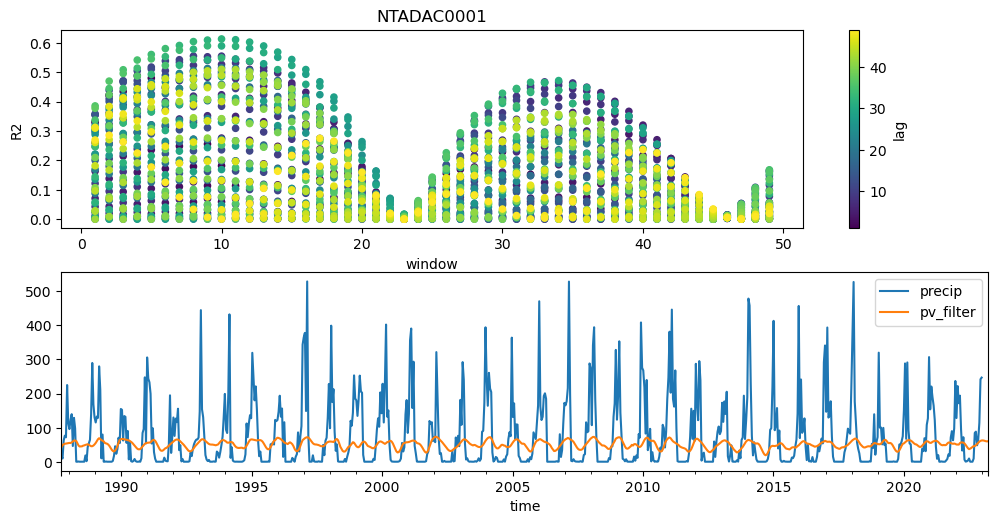

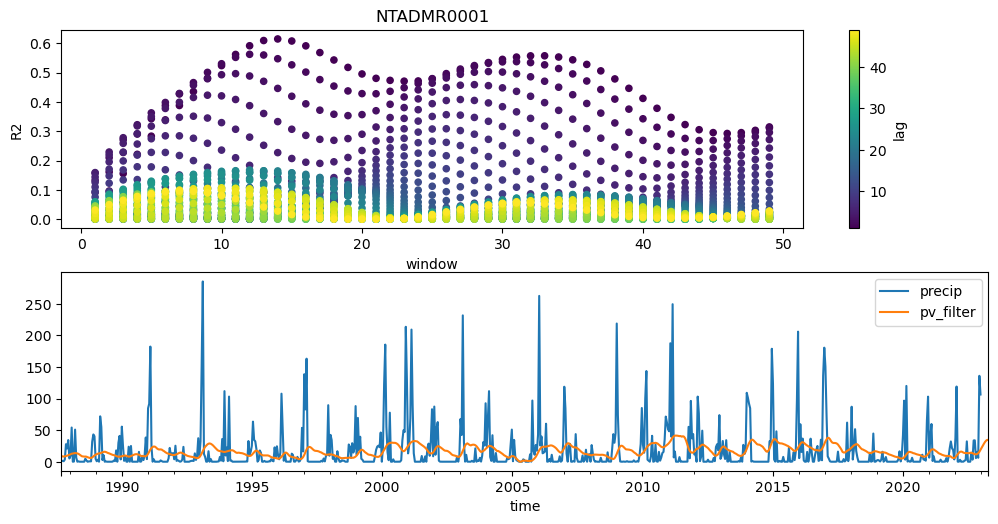

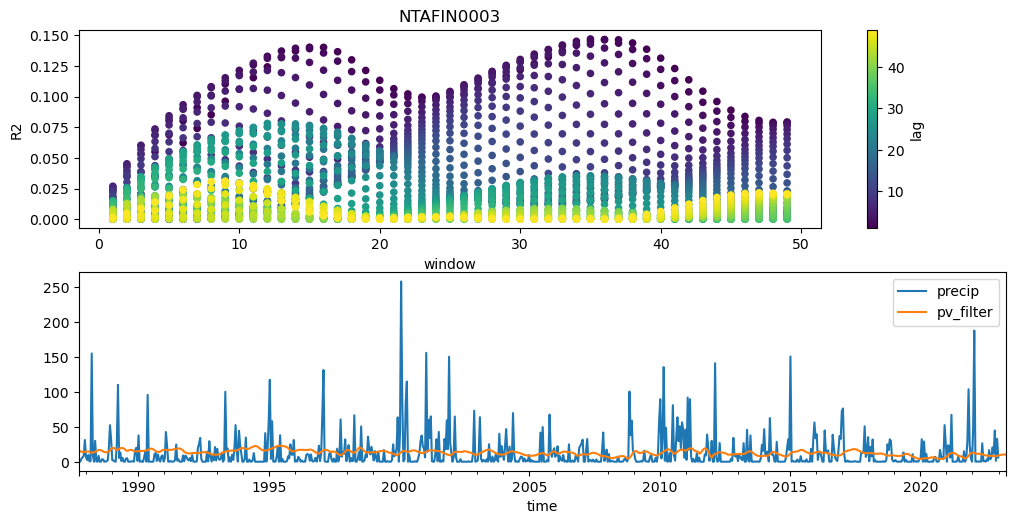

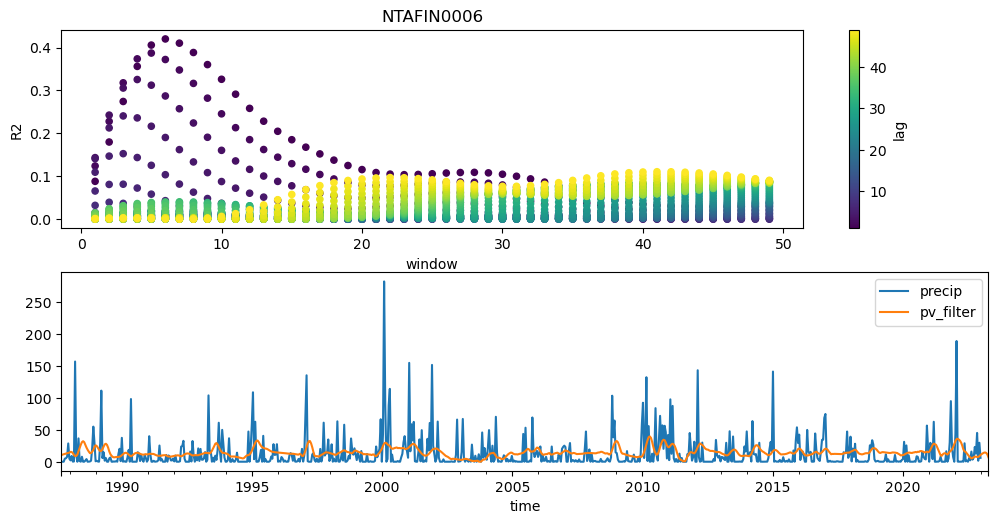

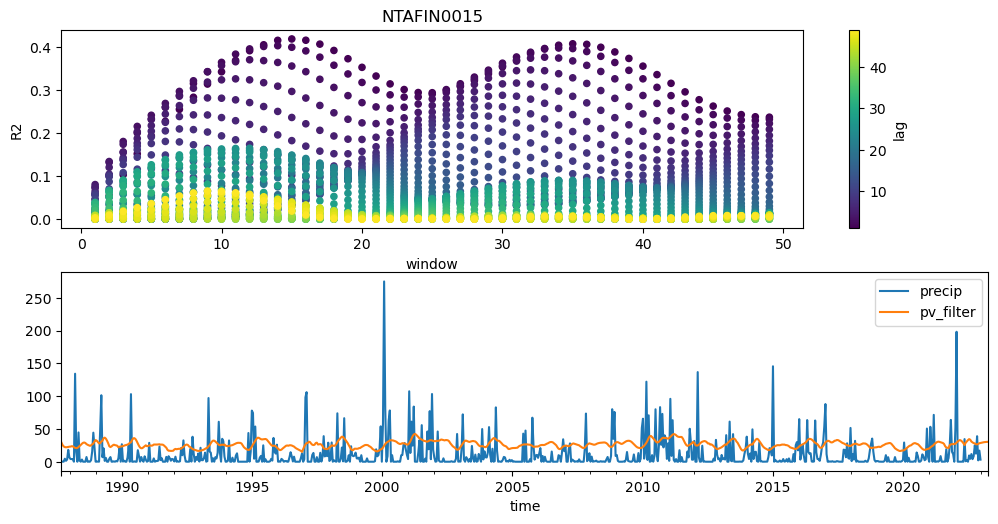

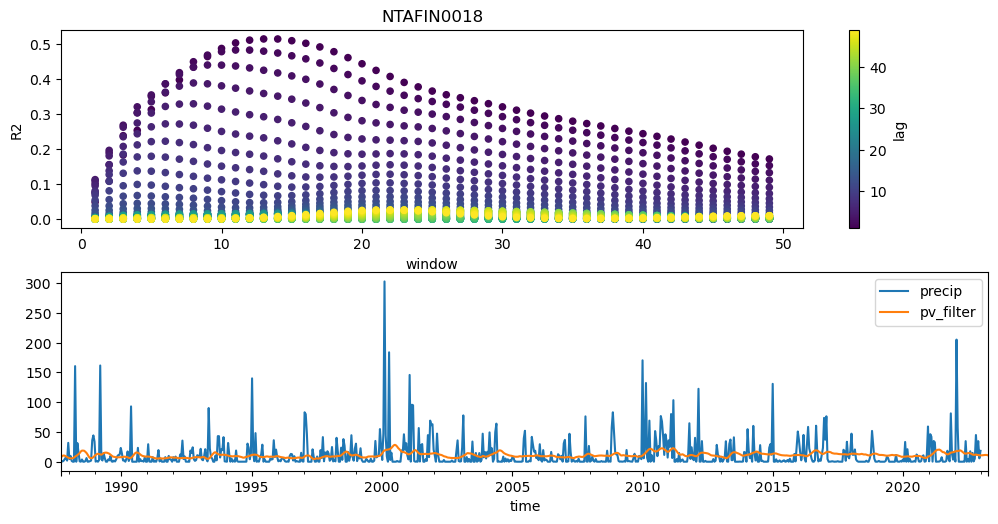

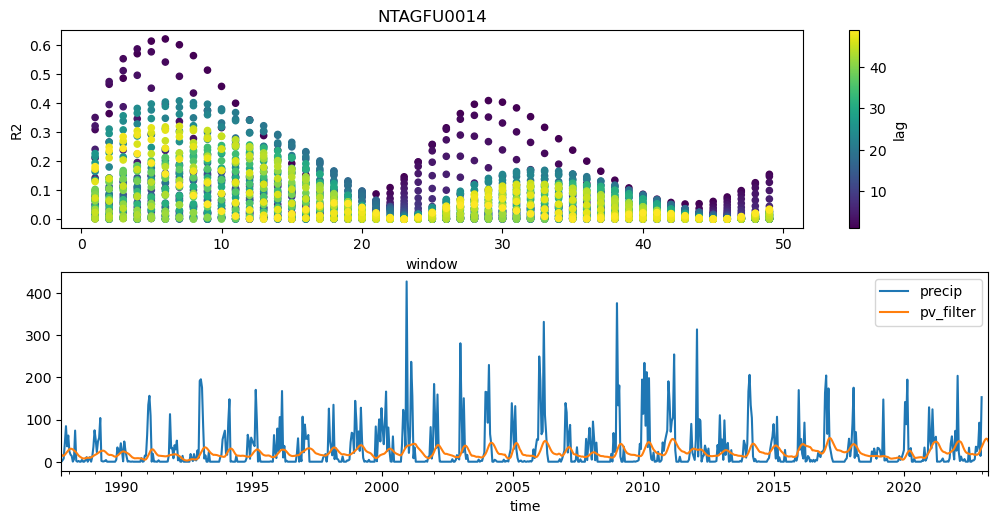

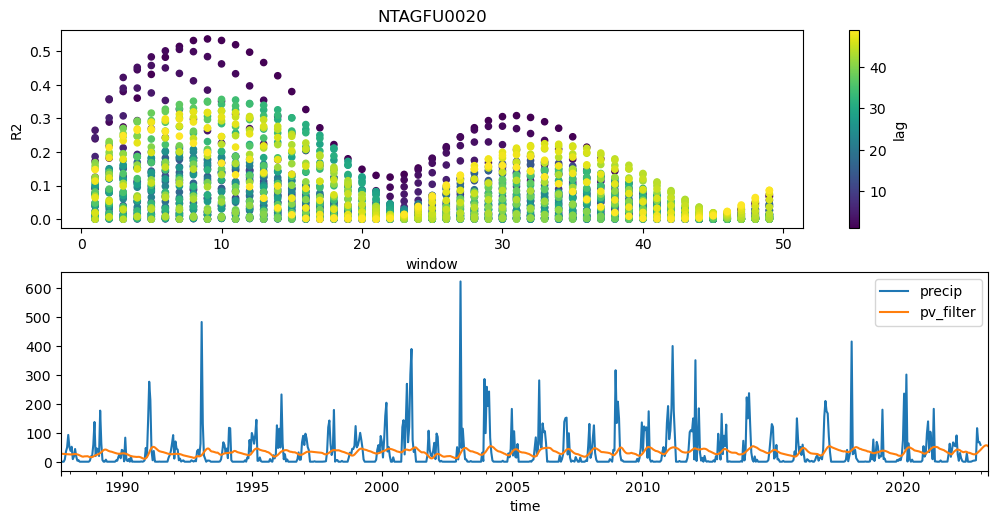

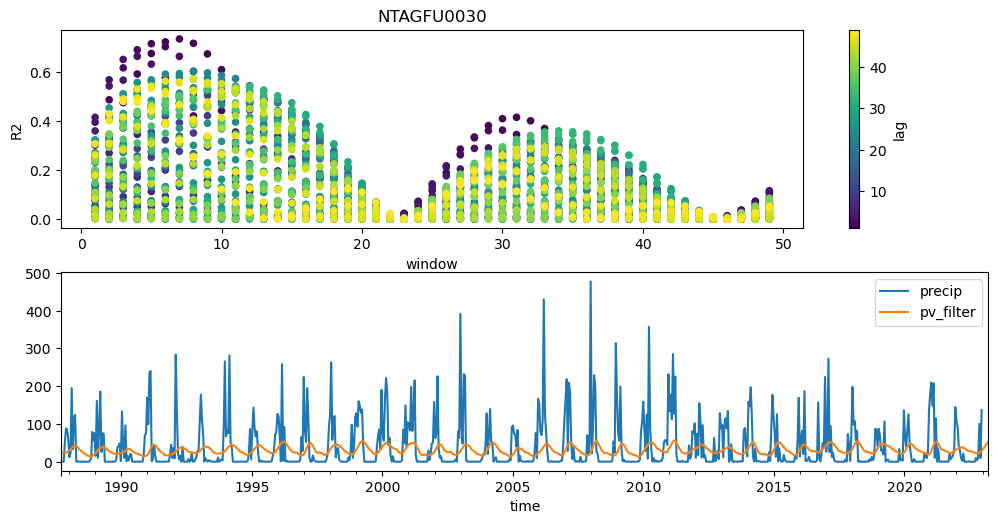

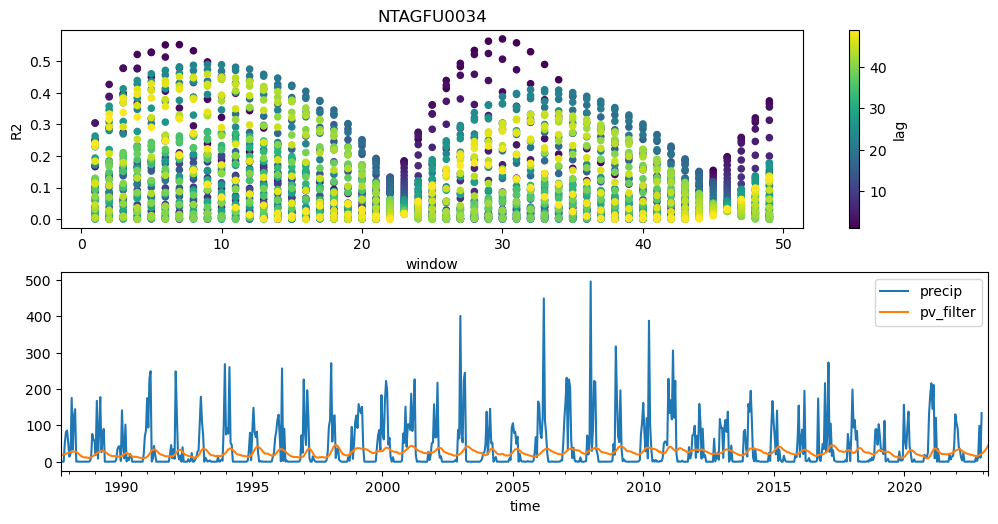

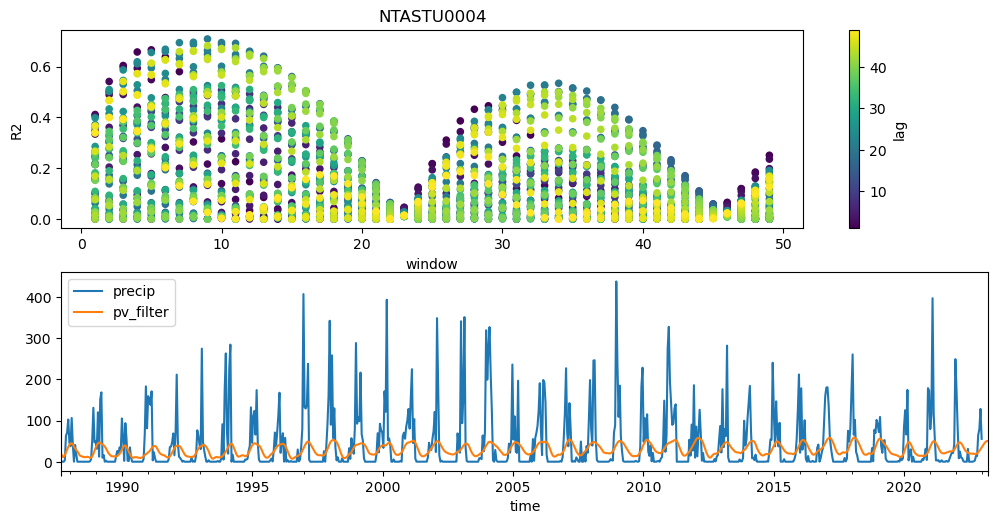

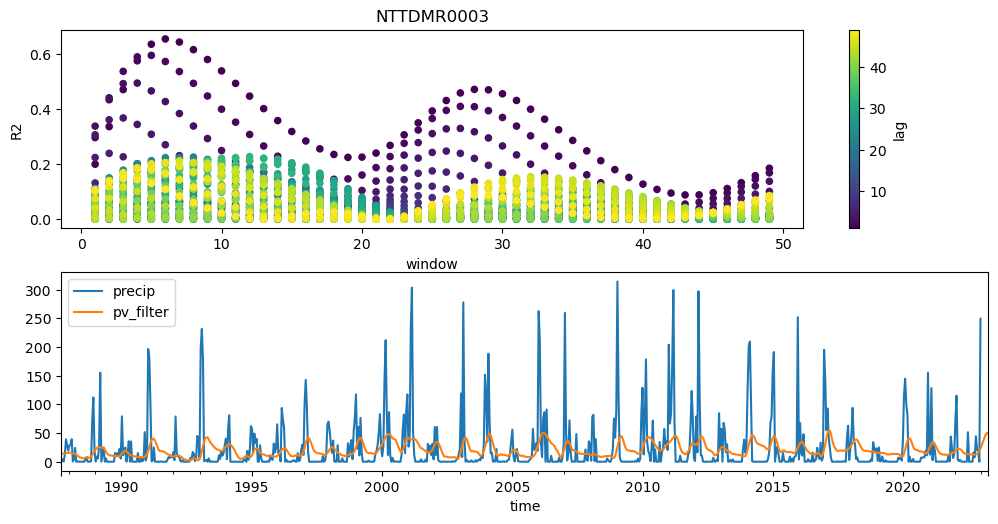

In [12]:
site_scores_grp = site_scores.groupby('site_location_name')

for key in site_scores_grp.groups.keys():
    fig, ax = plt.subplots(2, figsize = (10,5))
    fig.tight_layout()
    site = site_scores_grp.get_group(key)
    first_index = site.index[0] # information will be constant per group so take the first one for simplicity
    site.plot.scatter(x = 'window', y = 'R2', c = 'lag', colormap = 'viridis', title = f'{key}', ax = ax[0])
    site_data = get_site_data(key)
    site_data[['precip', 'pv_filter']].plot(ax = ax[1])
    

In [32]:
site_list_NT = site_list[site_list['site_location_name'].isin(NT_sites)]
site_list_NT

Unnamed: 0   V1 site_location_name  Aquatic  Bryophyte  Chenopod  Cycad  \
2            3  120         NTAFIN0015        0        0.0  0.000000      0   
11          12  172         NTAGFU0034        0        0.0  0.000000      0   
22          23  168         NTAGFU0030        0        0.0  0.000000      0   
27          28  108         NTAFIN0003        0        0.0  0.000000      0   
43          44  123         NTAFIN0018        0        0.0  5.300000      0   
61          62  217         NTTDMR0003        0        0.0  0.000000      0   
62          63  207         NTASTU0004        0        0.0  0.000000      0   
71          72  102         NTADAC0001        0        0.0  0.000000      0   
75          76  111         NTAFIN0006        0        0.0  0.333333      0   
77          78  158         NTAGFU0020        0        0.0  0.000000      0   
87          88  152         NTAGFU0014        0        0.0  0.000000      0   
88          89  104         NTADMR0001        0        0.0  0.000000      0   

    Epiphyte  Fern      Forb  ...  Shrub.Mallee  Tree.fern  Tree.Mallee  \
2        0.0   0.0  0.000000  ...           0.0          0          0.0   
11       0.0   0.0  0.000000  ...           0.0          0          0.0   
22       0.0   0.2  1.200000  ...           0.0          0          0.0   
27       0.0   0.0  0.666667  ...           0.0          0          0.0   
43       0.0   0.0  0.200000  ...           0.0          0          0.0   
61       0.0   0.0  2.700000  ...           0.0          0          0.0   
62       0.0   0.0  4.900000  ...           0.0          0          0.0   
71       0.0   0.0  1.300000  ...           0.0          0          0.0   
75       0.0   0.0  5.033333  ...           0.0          0          0.0   
77       0.0   0.0  1.800000  ...           0.0          0          0.5   
87       0.0   0.0  0.600000  ...           0.0          0          0.0   
88       0.0   0.0  0.100000  ...           0.0          0          0.0   

    Tree.Palm  Tussock.grass      Vine      grass      shrub       tree  \
2   31.100000      12.600000  0.000000  13.600000   3.100000  31.100000   
11  20.400000      13.200000  0.000000  13.200000  18.700000  20.400000   
22  49.500000      28.400000  0.000000  30.800000   3.100000  49.500000   
27  13.400000       9.800000  0.066667  10.466667   4.233333  13.400000   
43   0.100000       9.700000  0.000000   9.900000  25.100000   0.100000   
61   4.500000      30.600000  2.200000  48.700000   5.200000   4.500000   
62  20.600000      66.700000  4.500000  71.600000  10.400000  20.600000   
71  30.400000      97.400000  2.000000  98.700000  24.400000  30.400000   
75   0.166667       5.533333  0.000000  12.233333   1.766667   0.166667   
77   0.400000      47.500000  0.300000  64.000000  37.600000   0.900000   
87  13.200000      14.200000  0.000000  25.000000   1.700000  13.200000   
88   0.100000       1.200000  0.300000  22.200000   4.900000   0.100000   

    vegetation_type  
2              tree  
11             tree  
22             tree  
27             tree  
43            shrub  
61            grass  
62            grass  
71            grass  
75            grass  
77            grass  
87            grass  
88            grass  

[12 rows x 28 columns]

In [29]:
growth_type_classification = pd.read_csv('../DATASETS/Growth_Type_Classification.csv').copy()

In [78]:
site_list_NT_essential = site_list_NT[['site_location_name', 'shrub', 'tree', 'grass']].copy()
site_list_NT_essential = site_list_NT_essential.reset_index()
site_list_NT_essential.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               12 non-null     int64  
 1   site_location_name  12 non-null     object 
 2   shrub               12 non-null     float64
 3   tree                12 non-null     float64
 4   grass               12 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 612.0+ bytes


<Axes: xlabel='site_location_name'>

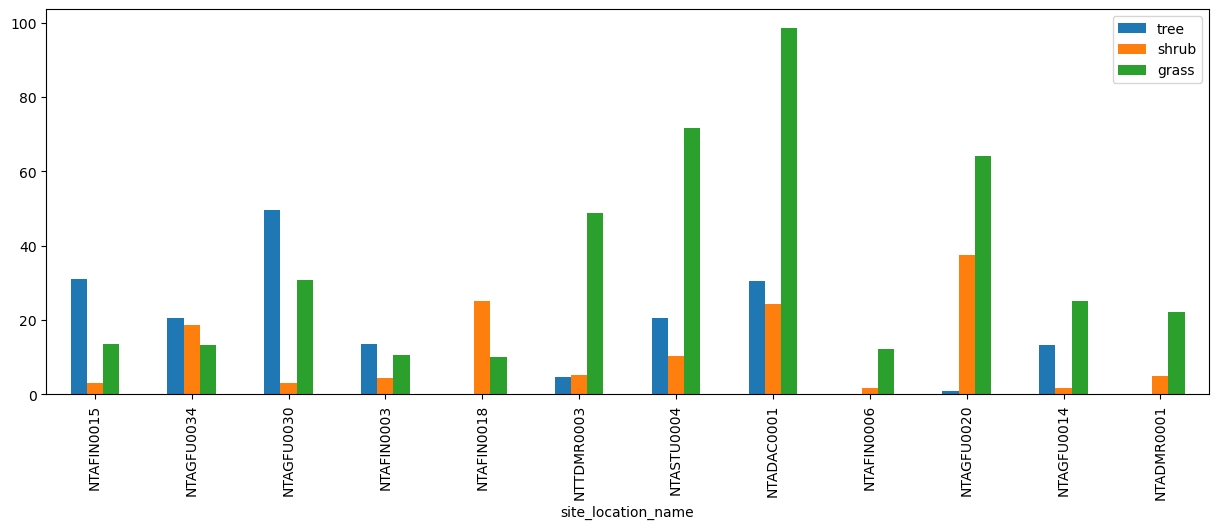

In [79]:
site_list_NT_essential.plot(kind = 'bar', x = 'site_location_name', y = ['tree', 'shrub', 'grass'], figsize = (15,5))

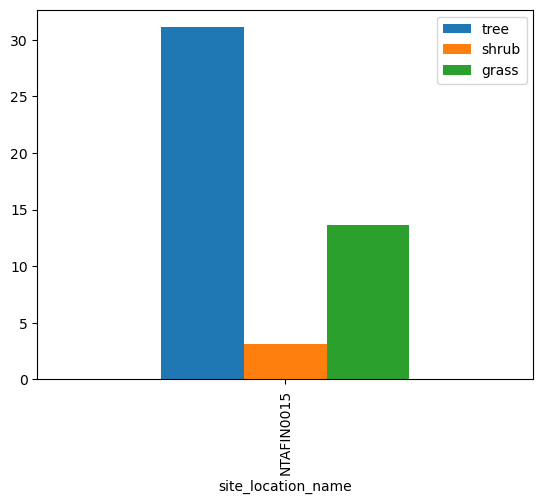

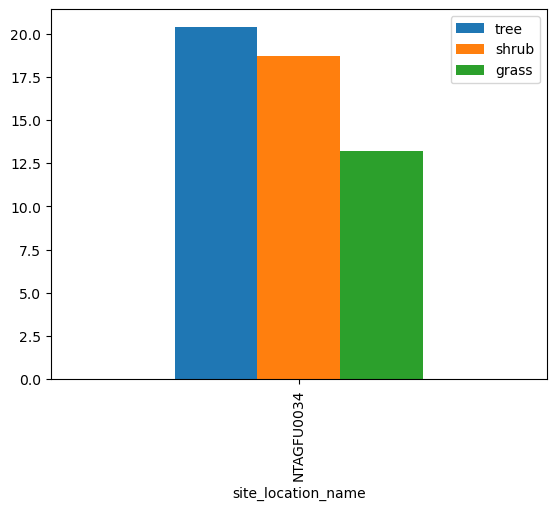

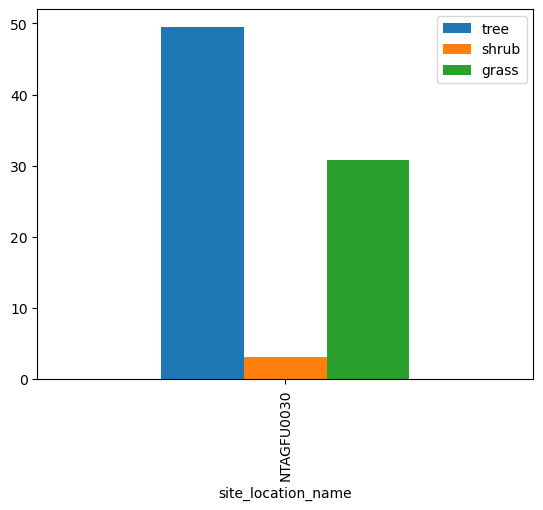

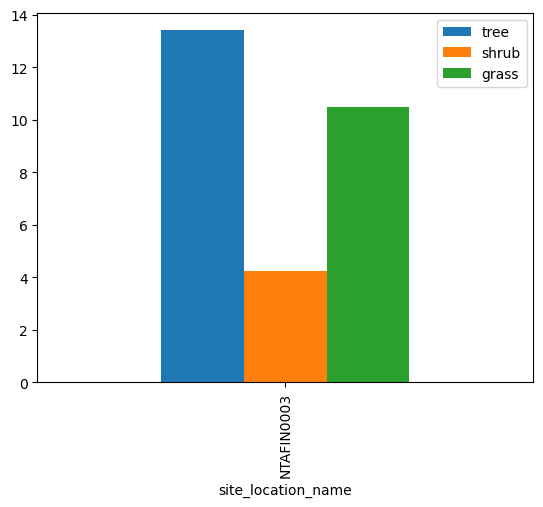

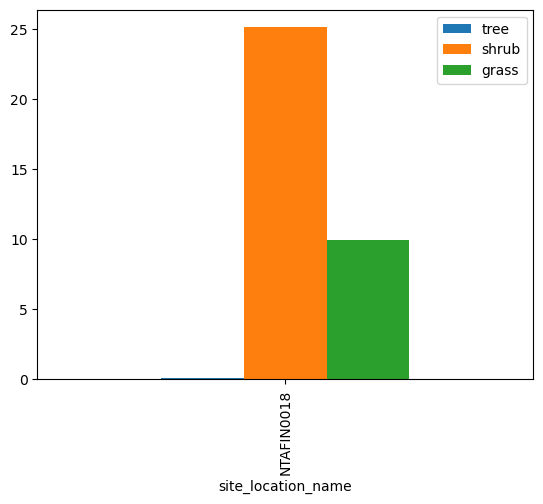

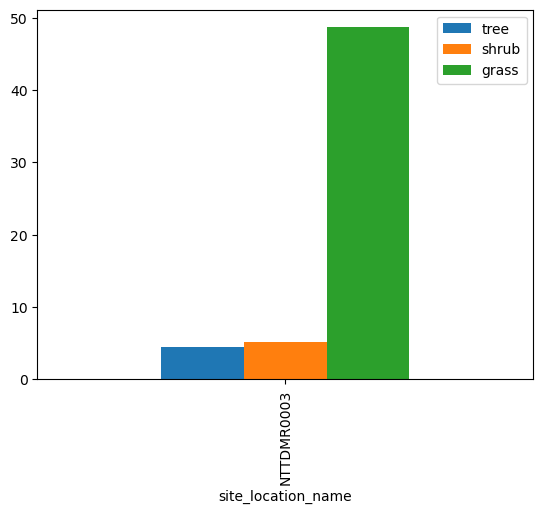

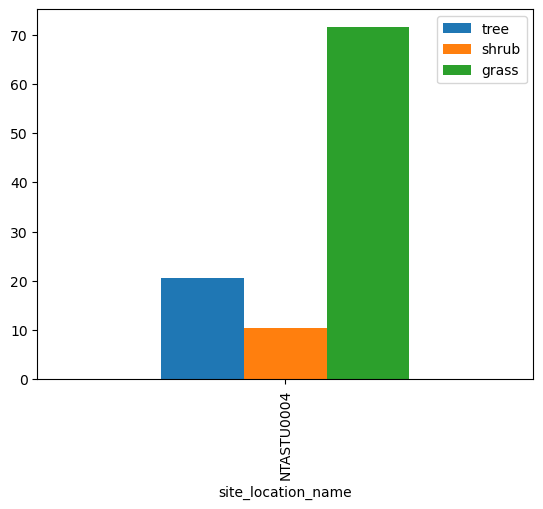

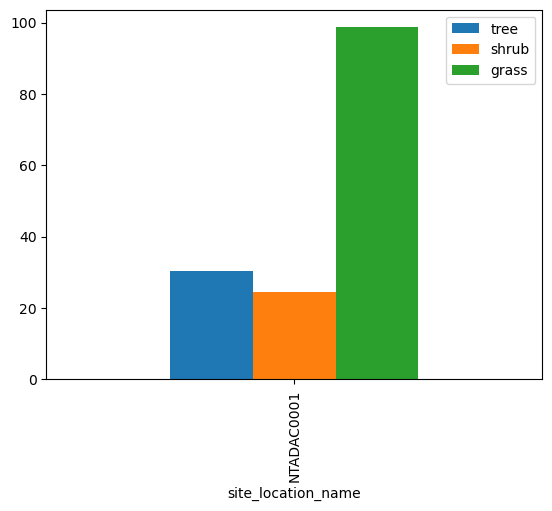

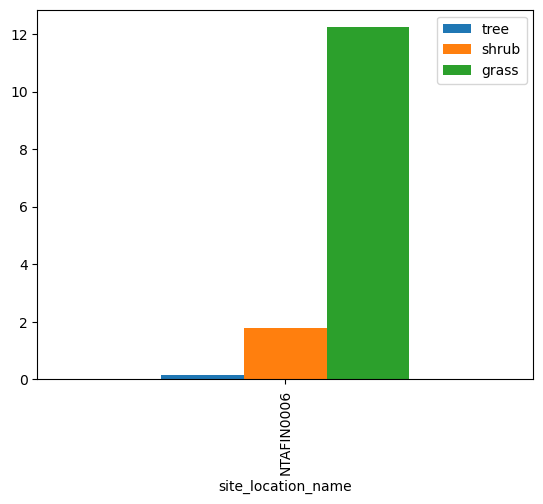

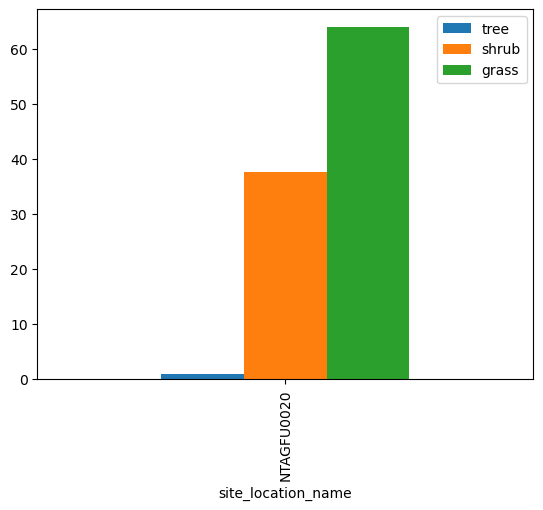

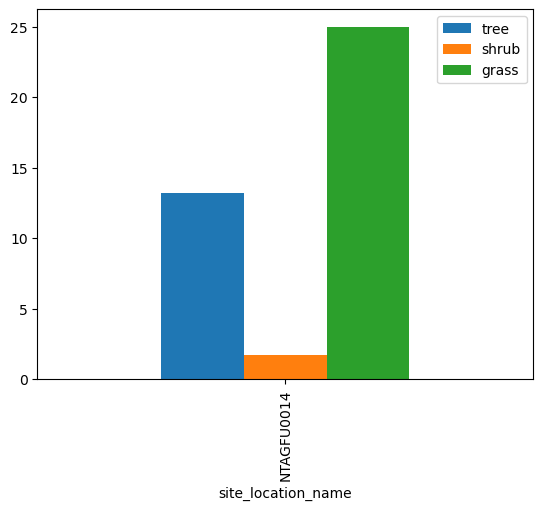

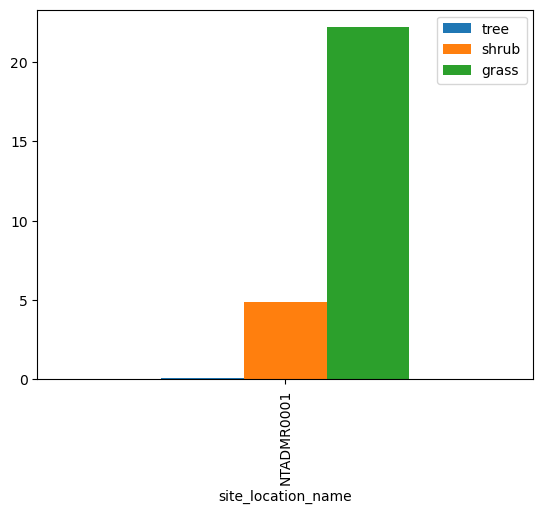

In [84]:
for i in site_list_NT_essential.index:
    site_list_NT_essential.iloc[[i]].plot(kind = 'bar', x = 'site_location_name', y = ['tree', 'shrub', 'grass'])